## Deep Learning on EuroSat

Note to users: this code can only run in satellite_env, which you can install from satellite_env.yml in the repo.

Running Jupyter on a conda environment is a huge pain in the a**, and I was about to give up.

To speed up training, we will load a pre-trained model and fine tune it.

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline 
# required for jupyter

import keras
from keras.preprocessing import image
from keras.applications import resnet50
from keras import models
from keras import layers
from keras import optimizers

#import cv2 # for computer vision
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [2]:
# see if we're in a virtual env
sys.prefix
#sys.real_prefix
#hasattr(sys, 'real_prefix')

'C:\\Users\\ZiAng\\Anaconda3\\envs\\satellite_env'

In [3]:
# io related
from skimage import io
from skimage import transform
from skimage import data

## Loading the pre-trained ResNet model


In [4]:
resnet_model = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

Instructions for updating:
Colocations handled automatically by placer.


C:\Users\ZiAng\Anaconda3\envs\satellite_env\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [5]:
resnet_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

## Create a New Model on top of ResNet
Now, we have all the trainable parameters of our base network, we would like to add a classifier on top of the convolutional base. We will simply add a fully connected layer followed by a softmax layer with 10 outputs. This is done as given below. See the huge number of trainable params, if we would have to train all those params from scratch think of how much computing resources and time it would take to converge to good results. Therefore, thanks to the Fine-Tuning technique for saving us!

In [6]:
# Adding model on top of convolutional model
# create model
model = models.Sequential()

# Add the resnet50
model.add(resnet_model)

# Adding new layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))  # Output layer, has 10 categories

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2, 2, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              8389632   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                10250     
Total params: 31,987,594
Trainable params: 31,934,474
Non-trainable params: 53,120
_________________________________________________________________


## Load data with Image Data Generator

"Image Data Generator" sounds almost as unreal as "Breastplate Stretcher" by King Robert.

In [8]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    validation_split = 0.2 # split train/validation automatically
    )

In [30]:
# Setting the path to EuroSat Dataset
path = os.path.join("..", "..", "final_feasibility", "EuroSat")
os.chdir(path)

In [10]:
# load training data (80%)
training_set = datagen.flow_from_directory(
    '2750',
    target_size=(64,64),
    batch_size=32,
    class_mode='categorical',
    subset='training'
    )

Found 21600 images belonging to 10 classes.


In [11]:
# load Validation data (20%)
validation_set = datagen.flow_from_directory(
    '2750',
    target_size=(64,64),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
    )

Found 5400 images belonging to 10 classes.


## Reading images and display

Categories:

Annual Crop

Forest

Herbaceous Vegetation

Highway

Industrial

Pasture

Permanent Crop

Residential

River

Sea/Lake

In [14]:
print('Training data: ', training_set[0][0].shape)
print('Validation data: ', validation_set[0][0].shape)

Training data:  (32, 64, 64, 3)
Validation data:  (32, 64, 64, 3)


[[[0.3677103  0.32112768 0.3561018 ]
  [0.37809142 0.32859707 0.36489555]
  [0.33878192 0.29286405 0.3323269 ]
  ...
  [0.35301194 0.3569335  0.376486  ]
  [0.324543   0.32846457 0.3467889 ]
  [0.3093392  0.31990197 0.33930093]]

 [[0.3479512  0.31143036 0.34584257]
  [0.36186385 0.3183714  0.35751274]
  [0.3460337  0.30756298 0.350426  ]
  ...
  [0.35146075 0.35538232 0.37483016]
  [0.32436478 0.32828635 0.34419313]
  [0.3034869  0.31404972 0.33305657]]

 [[0.34094778 0.3146028  0.34624457]
  [0.3394961  0.30925784 0.3507905 ]
  [0.3512032  0.32636258 0.37259635]
  ...
  [0.3380557  0.34197727 0.36143792]
  [0.34188974 0.3458113  0.3620174 ]
  [0.32336435 0.33446968 0.35325438]]

 ...

 [[0.375778   0.38174298 0.37836048]
  [0.36450094 0.3776422  0.37382153]
  [0.35886428 0.37908134 0.37384683]
  ...
  [0.42334265 0.39764392 0.40440318]
  [0.40378663 0.39140537 0.39462036]
  [0.39516142 0.38359722 0.3865885 ]]

 [[0.38147834 0.38130987 0.38101524]
  [0.3738116  0.3802106  0.37737426]


[[[0.25947532 0.30947804 0.3415024 ]
  [0.25945514 0.30948815 0.3414923 ]
  [0.2594349  0.30949825 0.34148216]
  ...
  [0.24284677 0.30951345 0.340886  ]
  [0.24283667 0.30950335 0.3408759 ]
  [0.24282655 0.30949324 0.3408658 ]]

 [[0.266112   0.30615973 0.3448207 ]
  [0.2660918  0.3061698  0.34481063]
  [0.2660716  0.3061799  0.3448005 ]
  ...
  [0.24919292 0.32191527 0.35026   ]
  [0.24917272 0.32187483 0.35022968]
  [0.24915251 0.32183442 0.35019934]]

 [[0.28187162 0.3210873  0.36030298]
  [0.28182107 0.3210368  0.36025247]
  [0.2817706  0.32098627 0.36020195]
  ...
  [0.24855581 0.3230656  0.35051662]
  [0.24856593 0.32307574 0.35052672]
  [0.24857603 0.32308584 0.35053682]]

 ...

 [[0.31921327 0.34666425 0.3803922 ]
  [0.31919307 0.34664404 0.3803922 ]
  [0.31917283 0.3466238  0.3803922 ]
  ...
  [0.24134319 0.30800986 0.34722555]
  [0.24133308 0.30799976 0.34721544]
  [0.24132296 0.30798963 0.34720534]]

 [[0.32799056 0.34901962 0.3825328 ]
  [0.32796025 0.34901962 0.38252273]


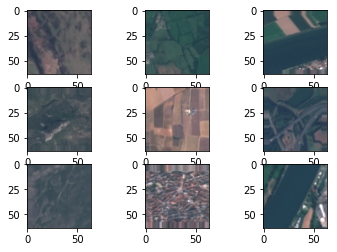

In [47]:
for i in range(0,9):
    plt.subplot(330+1+i)
    img = training_set[0][0][i]
    plt.imshow(img)
    print(img)
    
plt.show()

## Time to apply CNN on the data

In [19]:
#compile the model
model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])


In [34]:
# checkpoint
filepath = os.path.join("weights.best.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [35]:
path

'..\\..\\final_feasibility\\EuroSat'

In [36]:
# Train the model
history = model.fit_generator(
    training_set,
    steps_per_epoch = (training_set.samples/32),
    epochs = 20,
    callbacks=callbacks_list,
    validation_data = validation_set,
    validation_steps=(validation_set.samples/32)
)

Epoch 1/20
675/675 [==============================] - 1703s 3s/step - loss: 0.2481 - acc: 0.9335 - val_loss: 0.6615 - val_acc: 0.9133

Epoch 00001: val_acc improved from -inf to 0.91333, saving model to weights.best.hdf5
Epoch 2/20
675/675 [==============================] - 1702s 3s/step - loss: 0.2633 - acc: 0.9408 - val_loss: 2.4255 - val_acc: 0.8148

Epoch 00002: val_acc did not improve from 0.91333
Epoch 3/20
675/675 [==============================] - 1700s 3s/step - loss: 0.2622 - acc: 0.9481 - val_loss: 0.2776 - val_acc: 0.9417

Epoch 00003: val_acc improved from 0.91333 to 0.94167, saving model to weights.best.hdf5
Epoch 4/20
675/675 [==============================] - 1709s 3s/step - loss: 0.2254 - acc: 0.9526 - val_loss: 0.9983 - val_acc: 0.8983

Epoch 00004: val_acc did not improve from 0.94167
Epoch 5/20
675/675 [==============================] - 1700s 3s/step - loss: 0.2209 - acc: 0.9552 - val_loss: 0.6493 - val_acc: 0.8976

Epoch 00005: val_acc did not improve from 0.94167


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


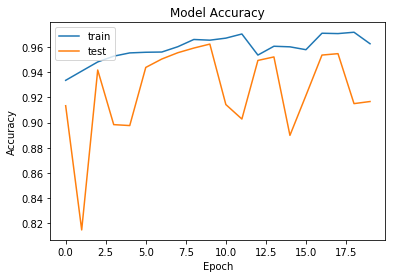

In [39]:
# Plotting the loss and accuracy
model.metrics_names
print(history.history.keys())

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc="upper left")
plt.show()

In [40]:
 # Load the model
from keras.models import load_model
filepath = os.path.join("..", "..", "data_bootcamp_final_project", "models", "deep_learning_eurosat.hdf5")
image_model = load_model(filepath)

In [44]:
image_model.predict(training_set[0][0][:]).round()

array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 

In [46]:
# view categories
training_set.class_indices

{'AnnualCrop': 0,
 'Forest': 1,
 'HerbaceousVegetation': 2,
 'Highway': 3,
 'Industrial': 4,
 'Pasture': 5,
 'PermanentCrop': 6,
 'Residential': 7,
 'River': 8,
 'SeaLake': 9}